# 04 — ETF Factor Regression

Builds the **time-varying factor exposure** of Korean ETFs via rolling OLS
against JKP 13-theme factors and the Korean market return.

**Analysis window: 2020-01-01 → 2023-12-31**
(bounded by `R_mkt` availability; see `etf_am_plan.md` for extension strategy)

| Output | Shape | Description |
|--------|-------|-------------|
| `R_etf` | (T, N) | Daily simple returns, NaN for pre-listing |
| `R_factor` | (T, 13) | JKP theme factor returns |
| `R_mkt` | (T, 1) | Korean VW market return |
| `R_factor_full` | (T, 14) | `R_mkt` prepended to `R_factor` — used as regression regressors |
| `ALPHA_w{60,120}` | (T, N) | Rolling intercept |
| `BETAS_w{60,120}` | (T, N, 14) | Rolling factor loadings (mkt + 13 JKP themes) |
| `RESID_w{60,120}` | (T, N) | Rolling idiosyncratic residual |

Reference: `docs/vibe/etf_am_plan.md`

---

## 1. Imports & Constants

In [30]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from utils.chkxp_ingest import open_etf_daily

# ── paths ────────────────────────────────────────────────────────────────────
CHKXP_RAW_DIR = Path("../data/raw/chkxp")
JKP_RAW_DIR   = Path("../data/raw/jkp")
CHKXP_DB_DIR  = Path("../data/db/chkxp/etf_daily")

# ── analysis parameters ──────────────────────────────────────────────────────
START_DATE = "2020-01-01"
END_DATE   = "2023-12-31"   # bounded by R_mkt availability (2023-12-28)
WINDOWS    = [60, 120]      # rolling window sizes in trading days

print(f"START_DATE : {START_DATE}")
print(f"END_DATE   : {END_DATE}")
print(f"WINDOWS    : {WINDOWS}")

START_DATE : 2020-01-01
END_DATE   : 2023-12-31
WINDOWS    : [60, 120]


---

## 2. ETF Return Matrix — R_etf (T × N)

Source: CHKXP daily CSV files via `open_etf_daily`.
Price column used: `현재가` (closing price).
Return = simple daily pct-change; NaN is preserved for pre-listing periods.

In [31]:
ds_etf = open_etf_daily(
    [
        CHKXP_RAW_DIR / "chkxp_etf(ACE)(KIWOOM)(PLUS)_from(20201010)_to(20260219).csv",
        CHKXP_RAW_DIR / "chkxp_etf(KODEX)_from(20201010)_to(20260219).csv",
        CHKXP_RAW_DIR / "chkxp_etf(RISE)(SOL)_from(20201010)_to(20260219).csv",
        CHKXP_RAW_DIR / "chkxp_etf(TIGER)_from(20201010)_to(20260219).csv",
    ],
    output_dir=CHKXP_DB_DIR,
)

df_etf = ds_etf.load()
print(f"Loaded  : {df_etf.shape[0]:,} rows × {df_etf.shape[1]} cols")
print(f"Columns : {list(df_etf.columns)}")

Loaded  : 355,723 rows × 16 cols
Columns : ['date', 'entity', 'entity_code', '현재가', '거래대금(30609과동일)', '시가총액', 'ETP지표가치(NAV/IV)', '추적오차율', 'ETP괴리율', 'ETP기초지수현재가', 'ETP구성종목수', '전일현금배당금액', '설정주식수', '전일환매주식수', '전일ETF순자산총액(백만)', 'year']


In [32]:
# ── filter date ──────────────────────────────────────────────────────────────
df_etf = df_etf[
    (df_etf["date"] >= pd.Timestamp(START_DATE)) &
    (df_etf["date"] <= pd.Timestamp(END_DATE))
].copy()

# ── strip CHKXP suffix: "069500*001" → "069500" ───────────────────────────────
df_etf["entity_code"] = df_etf["entity_code"].str.replace(r"\*\d+$", "", regex=True)

# ── pivot to wide: rows = date, cols = entity_code, values = 현재가 ──────────
price_wide = (
    df_etf
    .pivot_table(index="date", columns="entity_code", values="현재가", aggfunc="last")
    .sort_index()
)

# ── compute simple daily returns (pct_change preserves NaN for pre-listing) ──
R_etf = price_wide.pct_change()
R_etf = R_etf.iloc[1:]          # drop the first row (all NaN from pct_change)

T_etf, N = R_etf.shape
print(f"R_etf shape  : ({T_etf:,}, {N})")
print(f"date range   : {R_etf.index[0].date()} → {R_etf.index[-1].date()}")
print(f"ETFs (N)     : {N}")
print(f"NaN coverage : {R_etf.isna().sum().sum():,} cells out of {R_etf.size:,} "
      f"({R_etf.isna().mean().mean():.1%} pre-listing)")

R_etf shape  : (986, 194)
date range   : 2020-01-03 → 2023-12-28
ETFs (N)     : 194
NaN coverage : 49,962 cells out of 191,284 (26.1% pre-listing)


---

## 3. JKP Theme Factor Returns — R_factor (T × 13)

In [33]:
df_jkp_themes = pd.read_csv(
    JKP_RAW_DIR / "[kor]_[all_themes]_[daily]_[vw_cap].csv",
    parse_dates=["date"],
)

# ── filter date ──────────────────────────────────────────────────────────────
df_jkp_themes = df_jkp_themes[
    (df_jkp_themes["date"] >= pd.Timestamp(START_DATE)) &
    (df_jkp_themes["date"] <= pd.Timestamp(END_DATE))
]

# ── pivot: rows = date, cols = theme name, values = ret ──────────────────────
R_factor = (
    df_jkp_themes
    .pivot_table(index="date", columns="name", values="ret", aggfunc="last")
    .sort_index()
)
R_factor.columns.name = None

M = R_factor.shape[1]
print(f"R_factor shape : {R_factor.shape}")
print(f"date range     : {R_factor.index[0].date()} → {R_factor.index[-1].date()}")
print(f"Themes (M={M})  : {sorted(R_factor.columns.tolist())}")

R_factor shape : (988, 13)
date range     : 2020-01-02 → 2023-12-28
Themes (M=13)  : ['accruals', 'debt_issuance', 'investment', 'low_leverage', 'low_risk', 'momentum', 'profit_growth', 'profitability', 'quality', 'seasonality', 'short_term_reversal', 'size', 'value']


---

## 4. JKP Market Factor Return — R_mkt (T × 1)

In [34]:
df_jkp_mkt = pd.read_csv(
    JKP_RAW_DIR / "[kor]_[mkt]_[daily]_[vw_cap].csv",
    parse_dates=["date"],
)

# ── filter date ──────────────────────────────────────────────────────────────
df_jkp_mkt = df_jkp_mkt[
    (df_jkp_mkt["date"] >= pd.Timestamp(START_DATE)) &
    (df_jkp_mkt["date"] <= pd.Timestamp(END_DATE))
]

# ── pivot: rows = date, col = "mkt" ──────────────────────────────────────────
R_mkt = (
    df_jkp_mkt
    .pivot_table(index="date", columns="name", values="ret", aggfunc="last")
    .sort_index()
)
R_mkt.columns.name = None

print(f"R_mkt shape  : {R_mkt.shape}")
print(f"date range   : {R_mkt.index[0].date()} → {R_mkt.index[-1].date()}")
print(f"Column       : {R_mkt.columns.tolist()}")

R_mkt shape  : (987, 1)
date range   : 2020-01-02 → 2023-12-28
Column       : ['mkt']


---

## 5. Align Datasets — Inner Join on Common Dates

Per `etf_am_plan.md §2.3`: align `R_etf` and `R_factor` via **inner join**
so that every date has complete factor observations.
The market factor `R_mkt` is intersected last.

In [35]:
common_idx = (
    R_etf.index
    .intersection(R_factor.index)
    .intersection(R_mkt.index)
)

R_etf    = R_etf.loc[common_idx]
R_factor = R_factor.loc[common_idx]
R_mkt    = R_mkt.loc[common_idx]

# ── augmented factor matrix: market first, then 13 JKP themes ────────────────
# R_mkt is a genuine long-only factor; omitting it causes omitted-variable bias
# in the theme betas and inflates alpha for equity ETFs.
R_factor_full = pd.concat([R_mkt, R_factor], axis=1)   # (T, 14)

T = len(common_idx)
N = R_etf.shape[1]
M = R_factor_full.shape[1]   # 14 = 1 market + 13 JKP themes

print(f"Common dates   : {T:,}  ({common_idx[0].date()} → {common_idx[-1].date()})")
print(f"R_etf          : ({T}, {N})")
print(f"R_factor_full  : ({T}, {M})  [mkt + 13 JKP themes]")

Common dates   : 986  (2020-01-03 → 2023-12-28)
R_etf          : (986, 194)
R_factor_full  : (986, 14)  [mkt + 13 JKP themes]


---

## 6. Sanity Checks

In [36]:
# ── per-ETF: first valid return date and total valid observation count ─────────
etf_coverage = pd.DataFrame({
    "first_valid": R_etf.apply(lambda s: s.first_valid_index()),
    "valid_obs"  : R_etf.notna().sum(),
    "pct_valid"  : (R_etf.notna().sum() / T * 100).round(1),
})

print("ETF coverage summary:")
print(etf_coverage.describe())
print()
print(f"ETFs with full history ({T} obs) : "
      f"{(etf_coverage['valid_obs'] == T).sum()}")
print(f"ETFs with < 60 obs (unusable)    : "
      f"{(etf_coverage['valid_obs'] < 60).sum()}")
print(f"ETFs with < 120 obs               : "
      f"{(etf_coverage['valid_obs'] < 120).sum()}")

ETF coverage summary:
                      first_valid   valid_obs   pct_valid
count                         194  194.000000  194.000000
mean   2021-01-17 07:32:47.010000  728.463918   73.875773
min           2020-01-03 00:00:00   11.000000    1.100000
25%           2020-01-03 00:00:00  510.250000   51.750000
50%           2020-01-03 00:00:00  986.000000  100.000000
75%           2021-12-04 18:00:00  986.000000  100.000000
max           2023-12-13 00:00:00  986.000000  100.000000
std                           NaN  373.094025   37.846837

ETFs with full history (986 obs) : 119
ETFs with < 60 obs (unusable)    : 18
ETFs with < 120 obs               : 36


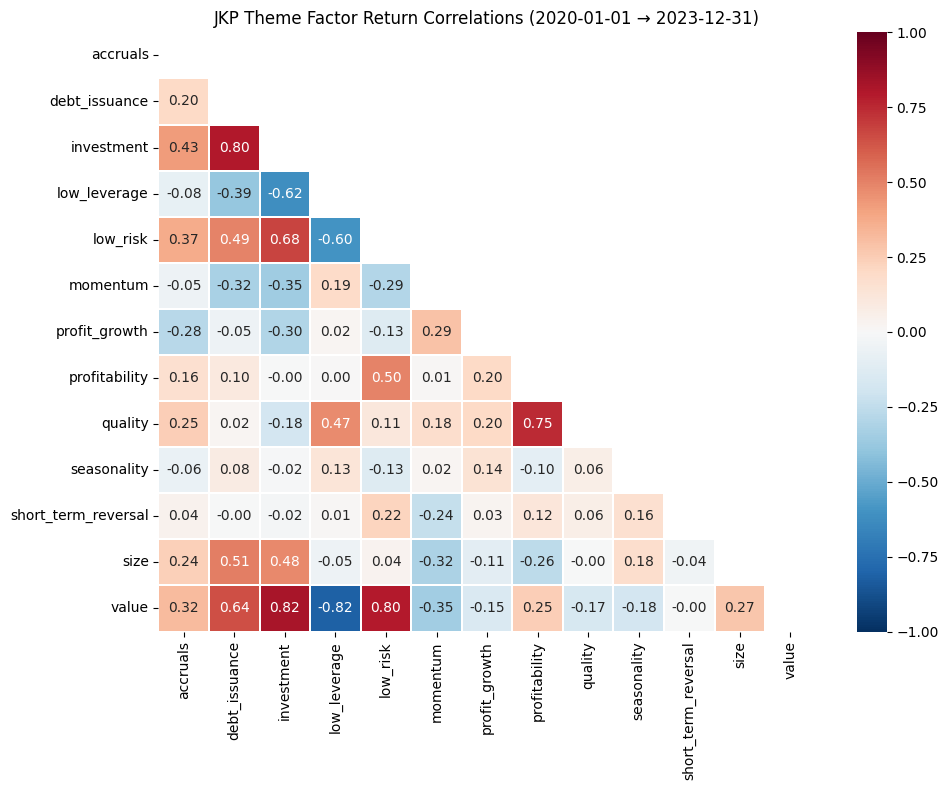

In [37]:
# ── factor correlation heatmap ───────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 8))
corr = R_factor.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.3,
    ax=ax,
)
ax.set_title(f"JKP Theme Factor Return Correlations ({START_DATE} → {END_DATE})", fontsize=12)
plt.tight_layout()
plt.show()

---

## 7. Rolling OLS Regression

For each ETF $i$ and each date $t$, estimate:

$$r_{i,t} = \alpha_i(t) + \boldsymbol{\beta}_i(t)^\top \mathbf{f}_t + \varepsilon_{i,t}$$

using the trailing $w$-day window via `np.linalg.lstsq`.

**Regressors:** `R_factor_full` = market return prepended to the 13 JKP themes → M=14.
Omitting the market return causes omitted-variable bias in the theme betas and inflates
alpha for all long-only equity ETFs.

**Implementation note:** `X_const` is built once as `(T, M+1) = (T, 15)` with a leading
ones column; for each window $[t-w+1, t]$ we slice the pre-built matrix — no
repeated `hstack` inside the inner loop.

In [38]:
# ── pre-compute arrays once ───────────────────────────────────────────────────
dates   = R_etf.index
tickers = R_etf.columns.tolist()

R_etf_arr    = R_etf.values.astype(np.float64)           # (T, N)
R_factor_arr = R_factor_full.values.astype(np.float64)   # (T, M=14)

# design matrix with intercept column: (T, M+1) = (T, 15)
X_const = np.hstack([np.ones((T, 1)), R_factor_arr])

# per-ETF: integer index of the first valid (non-NaN) return
first_valid_idx = {
    ticker: int(np.where(~np.isnan(R_etf_arr[:, i]))[0][0])
    if not np.all(np.isnan(R_etf_arr[:, i])) else T   # all-NaN → skip
    for i, ticker in enumerate(tickers)
}

print(f"Arrays ready — R_etf_arr {R_etf_arr.shape}, X_const {X_const.shape}")

Arrays ready — R_etf_arr (986, 194), X_const (986, 15)


In [39]:
import time

# ── results storage ───────────────────────────────────────────────────────────
results = {}   # keyed by window size

for window in WINDOWS:
    t0_wall = time.perf_counter()

    ALPHA = np.full((T, N), np.nan, dtype=np.float64)
    BETAS = np.full((T, N, M), np.nan, dtype=np.float64)
    RESID = np.full((T, N), np.nan, dtype=np.float64)

    for i, ticker in enumerate(tickers):
        t_first = first_valid_idx[ticker]
        t_start = t_first + window - 1   # earliest date with a full window

        if t_start >= T:
            continue

        for t in range(t_start, T):
            y_w = R_etf_arr[t - window + 1 : t + 1, i]   # (w,)

            if np.isnan(y_w).any():   # gap / trading halt → skip
                continue

            X_w = X_const[t - window + 1 : t + 1, :]     # (w, M+1)
            B, _, _, _ = np.linalg.lstsq(X_w, y_w, rcond=None)  # (M+1,)

            ALPHA[t, i]    = B[0]
            BETAS[t, i, :] = B[1:]
            RESID[t, i]    = R_etf_arr[t, i] - (B[0] + B[1:] @ R_factor_arr[t, :])

    elapsed = time.perf_counter() - t0_wall
    results[window] = {
        "ALPHA": pd.DataFrame(ALPHA, index=dates, columns=tickers),
        "BETAS": BETAS,
        "RESID": pd.DataFrame(RESID, index=dates, columns=tickers),
    }

    non_nan = (~np.isnan(ALPHA)).sum()
    print(f"w={window:3d} | elapsed {elapsed:6.1f}s | "
          f"ALPHA non-NaN cells: {non_nan:,} / {T*N:,} "
          f"({non_nan / (T*N):.1%})")

# convenience aliases
ALPHA_w60  = results[60]["ALPHA"]
BETAS_w60  = results[60]["BETAS"]
RESID_w60  = results[60]["RESID"]

ALPHA_w120 = results[120]["ALPHA"]
BETAS_w120 = results[120]["BETAS"]
RESID_w120 = results[120]["RESID"]

w= 60 | elapsed    5.1s | ALPHA non-NaN cells: 130,640 / 191,284 (68.3%)
w=120 | elapsed    5.3s | ALPHA non-NaN cells: 120,392 / 191,284 (62.9%)


---

## 8. Preview Outputs

In [40]:
# ── output shapes ─────────────────────────────────────────────────────────────
print("Output shapes")
print(f"  ALPHA_w60  : {ALPHA_w60.shape}")
print(f"  BETAS_w60  : {BETAS_w60.shape}")
print(f"  RESID_w60  : {RESID_w60.shape}")
print(f"  ALPHA_w120 : {ALPHA_w120.shape}")
print(f"  BETAS_w120 : {BETAS_w120.shape}")
print(f"  RESID_w120 : {RESID_w120.shape}")

Output shapes
  ALPHA_w60  : (986, 194)
  BETAS_w60  : (986, 194, 14)
  RESID_w60  : (986, 194)
  ALPHA_w120 : (986, 194)
  BETAS_w120 : (986, 194, 14)
  RESID_w120 : (986, 194)


In [41]:
# ── ALPHA snapshot for KODEX 200 (069500) ────────────────────────────────────
SAMPLE_TICKER = "069500"   # KODEX 200

if SAMPLE_TICKER in tickers:
    alpha_sample = pd.DataFrame({
        "alpha_w60" : ALPHA_w60[SAMPLE_TICKER],
        "alpha_w120": ALPHA_w120[SAMPLE_TICKER],
    }).dropna(how="all")
    print(f"ALPHA ({SAMPLE_TICKER}) — first 5 valid rows:")
    print(alpha_sample.dropna(how="any").head())
else:
    print(f"{SAMPLE_TICKER} not in universe; available tickers (first 10): {tickers[:10]}")

ALPHA (069500) — first 5 valid rows:
            alpha_w60  alpha_w120
date                             
2020-06-26   0.000248    0.000310
2020-06-29   0.000263    0.000220
2020-06-30   0.000284    0.000202
2020-07-01   0.000258    0.000196
2020-07-02   0.000084    0.000157


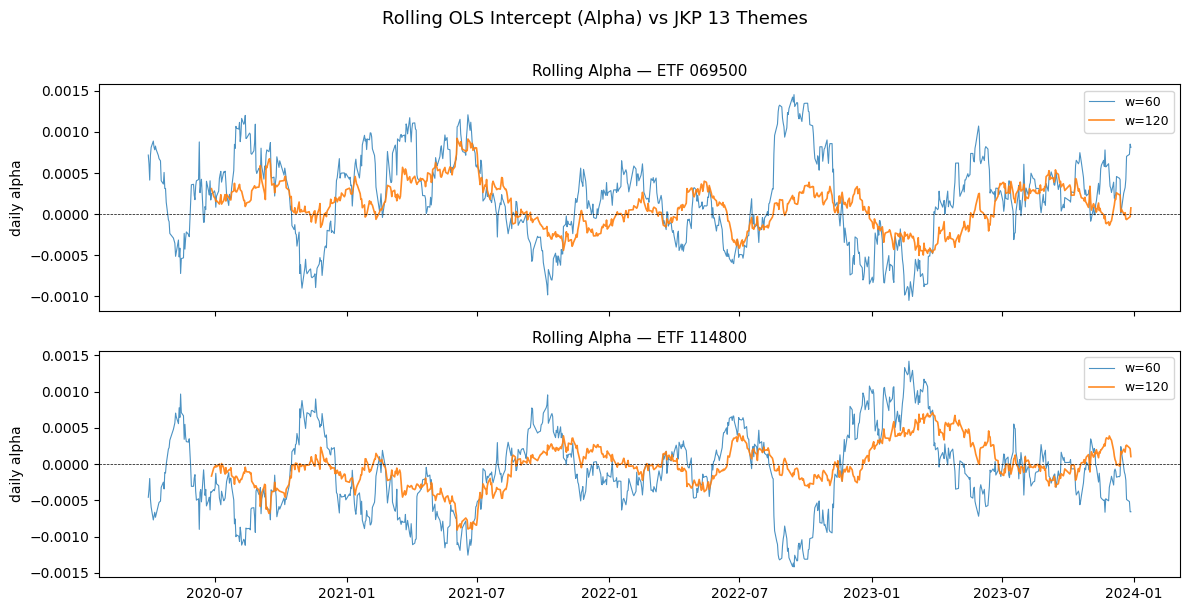

In [42]:
# ── rolling alpha plot for a representative ETF ───────────────────────────────
PLOT_TICKERS = [t for t in ["069500", "114800", "229200"] if t in tickers]

if PLOT_TICKERS:
    fig, axes = plt.subplots(len(PLOT_TICKERS), 1,
                              figsize=(12, 3 * len(PLOT_TICKERS)),
                              sharex=True)
    if len(PLOT_TICKERS) == 1:
        axes = [axes]

    for ax, ticker in zip(axes, PLOT_TICKERS):
        a60  = ALPHA_w60[ticker].dropna()
        a120 = ALPHA_w120[ticker].dropna()

        ax.plot(a60.index,  a60,  lw=0.8, label="w=60",  alpha=0.8)
        ax.plot(a120.index, a120, lw=1.2, label="w=120", alpha=0.9)
        ax.axhline(0, color="black", lw=0.5, ls="--")
        ax.set_title(f"Rolling Alpha — ETF {ticker}", fontsize=11)
        ax.set_ylabel("daily alpha")
        ax.legend(fontsize=9)
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

    fig.suptitle("Rolling OLS Intercept (Alpha) vs JKP 13 Themes", fontsize=13, y=1.01)
    plt.tight_layout()
    plt.show()
else:
    print("None of the sample tickers found in universe.")

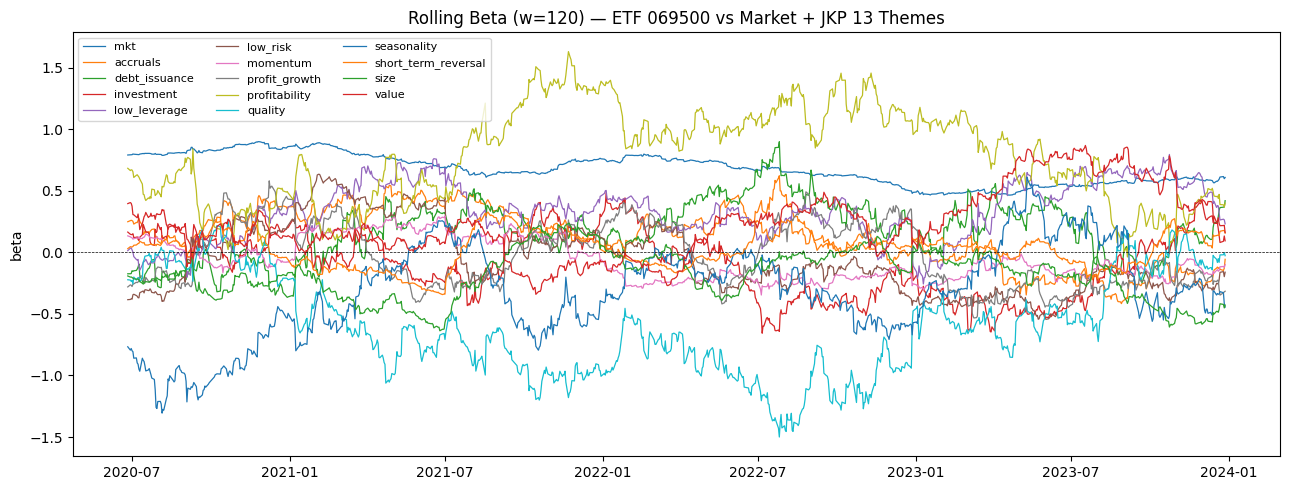

In [43]:
# ── rolling betas for KODEX 200 (069500) — all 13 themes ─────────────────────
if SAMPLE_TICKER in tickers:
    i_sample = tickers.index(SAMPLE_TICKER)

    betas_120 = pd.DataFrame(
        BETAS_w120[:, i_sample, :],
        index=dates,
        columns=R_factor_full.columns,
    ).dropna(how="all")

    fig, ax = plt.subplots(figsize=(13, 5))
    for col in betas_120.columns:
        ax.plot(betas_120.index, betas_120[col], lw=0.9, label=col)

    ax.axhline(0, color="black", lw=0.5, ls="--")
    ax.set_title(f"Rolling Beta (w=120) — ETF {SAMPLE_TICKER} vs Market + JKP 13 Themes",
                 fontsize=12)
    ax.set_ylabel("beta")
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.legend(fontsize=8, ncol=3, loc="upper left")
    plt.tight_layout()
    plt.show()